In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [2]:

addresses_df = pd.read_csv('nodes-addresses.csv')
entities_df = pd.read_csv('nodes-entities.csv')
intermediaries_df = pd.read_csv('nodes-intermediaries.csv') 
officers_df = pd.read_csv('nodes-officers.csv')
relationships_df = pd.read_csv('relationships.csv')
others_df = pd.read_csv('nodes-others.csv')

/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_88680/2247697261.py:2: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_88680/2247697261.py:5: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
merged_df = pd.read_csv('ICIJ_Merged.csv')

/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_88680/1195876193.py:1: DtypeWarning: Columns (4,5,6,7,8,10,11,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,37,39,40,41,42,43,45,46,47,48,49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
merged_df.head()

,node_id_start,node_id_end,rel_type,link,status,start_date,end_date,sourceid,address_start,name_start,...,internal_id_end,incorporation_date_end,inactivation_date_end,struck_off_date_end,dorm_date_end,status_end,service_provider_end,ibcruc_end,type_end,closed_date_end
0,10002580,14106952,registered_address,registered address,NaN,NaN,NaN,Panama Papers,STEMBRIDGE TRUST (IRELAND) LIMITED 5 THE COURT...,FUSION TRADING LIMITED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10004460,14101133,registered_address,registered address,NaN,NaN,NaN,Panama Papers,MF CORPORATE (UK) LIMITED 520 S. 7TH STREET SU...,MF CORPORATE (UK) LIMITED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10023813,14105100,registered_address,registered address,NaN,NaN,NaN,Panama Papers,REIG INVESTMENTS LLP INVISION HOUSE WILBURY WA...,REIG INVESTMENTS LLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10023840,14100712,registered_address,registered address,NaN,NaN,NaN,Panama Papers,MARCUSSI INTERNATIONAL LLP INVISION HOUSE WILB...,MARCUSSI INTERNATIONAL LLP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10010428,14093957,registered_address,registered address,NaN,NaN,NaN,Panama Papers,COLLYER BRISTOW LLP SOLICITORS 4 BEDFORD ROW L...,PULSAR HOLDINGS CORPORATION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Top 10 countries for entities (based on start_country, semicolon separated values counted individually):
countries_end
British Virgin Islands    56520
Aruba                     48683
Barbados                  40306
Hong Kong                 13735
Cayman Islands            10999
Bermuda                    9560
United Kingdom             9074
Russia                     7389
United States              5266
Seychelles                 3024
Name: node_id_start, dtype: int64


<Axes: xlabel='countries_end'>

Text(0.5, 1.0, 'Top 10 Countries for Entities to be physically based in')

Text(0.5, 0, 'Country')

Text(0, 0.5, 'Number of Entities')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'British Virgin Islands'),
  Text(1, 0, 'Aruba'),
  Text(2, 0, 'Barbados'),
  Text(3, 0, 'Hong Kong'),
  Text(4, 0, 'Cayman Islands'),
  Text(5, 0, 'Bermuda'),
  Text(6, 0, 'United Kingdom'),
  Text(7, 0, 'Russia'),
  Text(8, 0, 'United States'),
  Text(9, 0, 'Seychelles')])

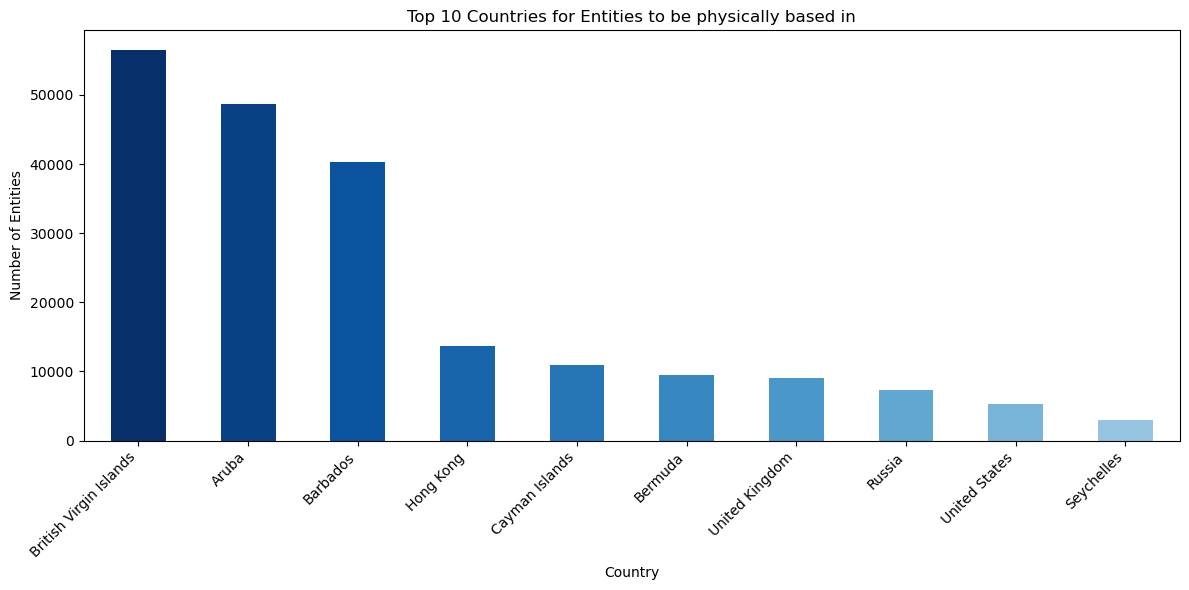

In [ ]:
# Filter for rows where an “Entity” is linked to an “Address”
# (i.e. node_type_start == 'entity' and node_type_end == 'address')
entity_to_address = merged_df[
    (merged_df["node_type_start"] == "entity") &
    (merged_df["node_type_end"]   == "address")
]

# Count how many distinct entities are linked to each address‐country
# (assuming the address country is in the column "countries_end")
top_countries = (
    entity_to_address
    .groupby("countries_end")["node_id_start"]   # “start_id” is the entity’s node ID
    .nunique()                              # count distinct entities per country
    .sort_values(ascending=False) 
)


top_10_entity_countries = top_countries.nlargest(10)

print("Top 10 countries for entities (based on start_country, semicolon separated values counted individually):")
print(top_10_entity_countries)

# Create a bar plot for the top 10 countries
# Sort the data for gradient coloring
sorted_countries = top_10_entity_countries.sort_values(ascending=False)
# Create a color map from light blue to dark blue
colors = plt.cm.Blues(np.linspace(1, 0.4, len(sorted_countries))) # Darkest for highest, lighter for lower

sorted_countries.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Top 10 Countries for Entities to be physically based in')
plt.xlabel('Country')
plt.ylabel('Number of Entities')
plt.xticks(rotation=45, ha='right') # Adjusted rotation for better label visibility
plt.tight_layout()
plt.show()


In [8]:
# # Filter for entities

# entity_rels = entities_df

# # Create a new series by splitting countries_start by semicolon and exploding the list
# # This handles NaN values by first filling them with an empty string, then filtering out empty strings after split
# split_countries = entity_rels['countries'].fillna('').str.split(';').explode()

# # Remove any empty strings that might result from splitting or from original NaNs
# split_countries = split_countries[split_countries != '']

# # Get the top 10 countries for entities
# value_counts = split_countries.value_counts()
# # Filter out "Not identified" before getting the top 10
# filtered_value_counts = value_counts[value_counts.index != 'Not identified']
# top_10_entity_countries = filtered_value_counts.nlargest(10)

# print("Top 10 countries for entities (based on start_country, semicolon separated values counted individually):")
# print(top_10_entity_countries)

# # Create a bar plot for the top 10 countries
# # Sort the data for gradient coloring
# sorted_countries = top_10_entity_countries.sort_values(ascending=False)
# # Create a color map from light blue to dark blue
# colors = plt.cm.Blues(np.linspace(1, 0.4, len(sorted_countries))) # Darkest for highest, lighter for lower

# sorted_countries.plot(kind='bar', figsize=(12, 6), color=colors)
# plt.title('Top 10 Countries for Entities to be physically based in')
# plt.xlabel('Country')
# plt.ylabel('Number of Entities')
# plt.xticks(rotation=45, ha='right') # Adjusted rotation for better label visibility
# plt.tight_layout()
# plt.show()

Top 10 jurisdictions for entities (based on jurisdiction_description_start):
jurisdiction_description
Bahamas                   209713
British Virgin Islands    172389
Malta                      83939
Saint Kitts and Nevis      70604
Undetermined               53571
Aruba                      49050
Panama                     48691
Barbados                   40846
Seychelles                 16886
Samoa                      15019
Name: count, dtype: int64


<Axes: xlabel='jurisdiction_description'>

Text(0.5, 1.0, 'Top 10 Jurisdictions for Entities')

Text(0.5, 0, 'Jurisdiction')

Text(0, 0.5, 'Number of Entities')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Bahamas'),
  Text(1, 0, 'British Virgin Islands'),
  Text(2, 0, 'Malta'),
  Text(3, 0, 'Saint Kitts and Nevis'),
  Text(4, 0, 'Undetermined'),
  Text(5, 0, 'Aruba'),
  Text(6, 0, 'Panama'),
  Text(7, 0, 'Barbados'),
  Text(8, 0, 'Seychelles'),
  Text(9, 0, 'Samoa')])

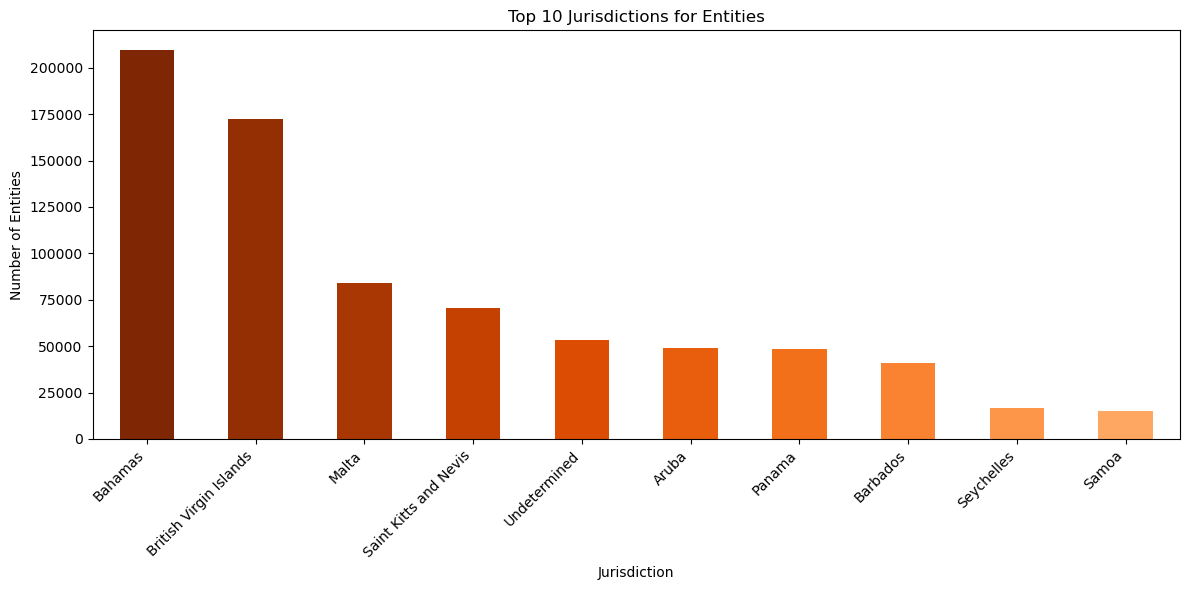

In [ ]:
# Filter for entities

entity_rels2 = entities_df

# Get the top 10 jurisdictions for entities
jurisdiction_counts = entity_rels2['jurisdiction_description'].value_counts()
# Filter out "Undetermined" before getting the top 10
filtered_jurisdiction_counts = jurisdiction_counts[jurisdiction_counts.index != 'Undetermined']
top_10_entity_jurisdictions = filtered_jurisdiction_counts.nlargest(10)

top_10_entity_jurisdictions = jurisdiction_counts.nlargest(10)

print("Top 10 jurisdictions for entities (based on jurisdiction_description_start):")
print(top_10_entity_jurisdictions)

# Create a bar plot for the top 10 jurisdictions
# Sort the data for gradient coloring
#sorted_jurisdictions = top_10_entity_jurisdictions.sort_values(ascending=False)

sorted_jurisdictions = top_10_entity_jurisdictions

# Create a color map from light orange to dark orange
colors = plt.cm.Oranges(np.linspace(1, 0.4, len(sorted_jurisdictions))) # Darkest for highest, lighter for lower

sorted_jurisdictions.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Top 10 Jurisdictions for Entities')
plt.xlabel('Jurisdiction')
plt.ylabel('Number of Entities')
plt.xticks(rotation=45, ha='right') # Added ha='right' for better label visibility
plt.tight_layout()
plt.show()


In [ ]:
entities_df.head()

,node_id,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,...,struck_off_date,dorm_date,status,service_provider,ibcRUC,country_codes,countries,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.","TIANSHENG INDUSTRY AND TRADING CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001256.0,23-MAR-2006,...,15-FEB-2013,NaN,Defaulted,Mossack Fonseca,25221,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.","NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001263.0,27-MAR-2006,...,15-FEB-2014,NaN,Defaulted,Mossack Fonseca,25249,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
2,10000003,"HOTFOCUS CO., LTD.","HOTFOCUS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000896.0,10-JAN-2006,...,15-FEB-2012,NaN,Defaulted,Mossack Fonseca,24138,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.","SKY-BLUE GIFTS & TOYS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000914.0,06-JAN-2006,...,15-FEB-2009,NaN,Defaulted,Mossack Fonseca,24012,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,FORTUNEMAKER INVESTMENTS CORPORATION,NaN,SAM,Samoa,NaN,LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...,1001266.0,19-APR-2006,...,15-FEB-2008,NaN,Changed agent,Mossack Fonseca,R25638,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN


Top 10 entity types:
company_type
Standard International Company                 40072
Standard Company under IBC Act                 26214
Business Company Limited by Shares             25130
Regular (Local) Company                        17599
Business Corporation                           16244
Client Sundry Account                           8692
International Trust                              999
Cook Islands Asset Protection Trust              547
Domestic Company                                 462
Cook Islands Asset Protection Trust - 3520A      445
Name: count, dtype: int64


<Axes: xlabel='company_type'>

Text(0.5, 1.0, 'Top 10 Entity Types')

Text(0.5, 0, 'Entity Type')

Text(0, 0.5, 'Number of Entities')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Standard International Company'),
  Text(1, 0, 'Standard Company under IBC Act'),
  Text(2, 0, 'Business Company Limited by Shares'),
  Text(3, 0, 'Regular (Local) Company'),
  Text(4, 0, 'Business Corporation'),
  Text(5, 0, 'Client Sundry Account'),
  Text(6, 0, 'International Trust'),
  Text(7, 0, 'Cook Islands Asset Protection Trust'),
  Text(8, 0, 'Domestic Company'),
  Text(9, 0, 'Cook Islands Asset Protection Trust - 3520A')])

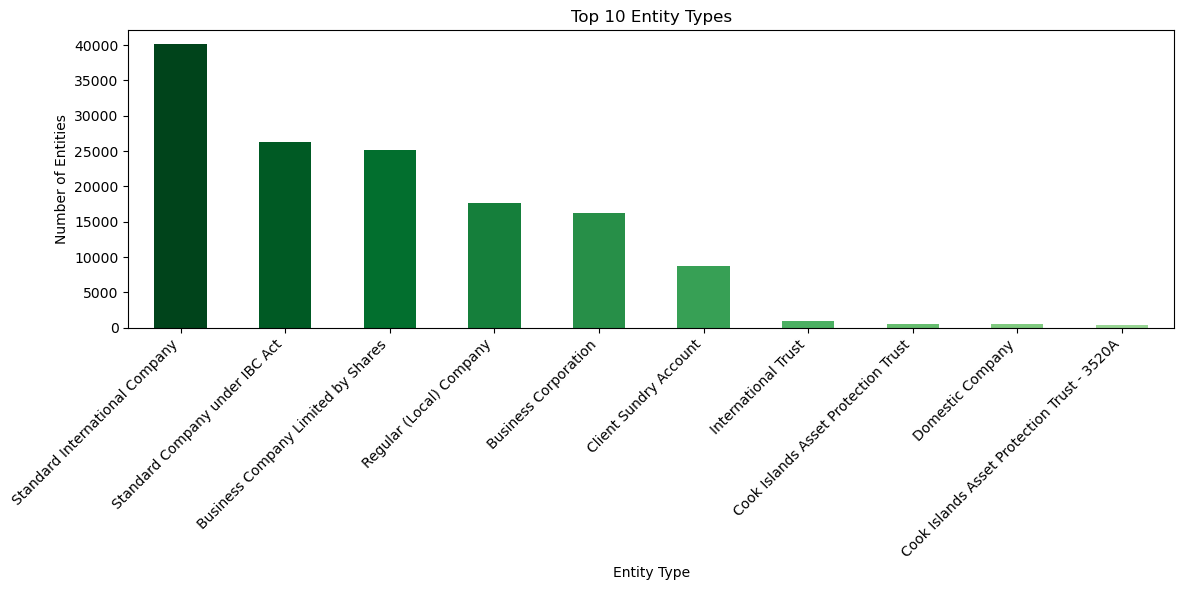

In [ ]:
# Get the top 10 entity types
entity_type_counts = entities_df['company_type'].value_counts()
top_10_entity_types = entity_type_counts.nlargest(10)

print("Top 10 entity types:")
print(top_10_entity_types)

# Create a bar plot for the top 10 entity types
# Sort the data for gradient coloring
sorted_entity_types = top_10_entity_types.sort_values(ascending=False)

# Create a color map from light green to dark green
colors = plt.cm.Greens(np.linspace(1, 0.4, len(sorted_entity_types))) # Darkest for highest, lighter for lower

sorted_entity_types.plot(kind='bar', figsize=(12, 6), color=colors)
plt.title('Top 10 Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Number of Entities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()